In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pacmap
import umap
import openTSNE
import trimap
import json

from collections import Counter
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [2]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10)
# skf.get_n_splits(X, y)

In [3]:
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from fa2 import ForceAtlas2 as FA2
def transform_by_FA2(X, n_neighbors=15):
    if X.shape[1] > 100:
        p = PCA(n_components=100)
        X = p.fit_transform(X)

    n = NearestNeighbors(n_neighbors=n_neighbors)
    n.fit(X)
    
    # Construct the graph
    A = n.kneighbors_graph(X)
    # A = A.toarray()
    A += A.T
    A = (A > 0).astype(int)

    # Initialize the graph.
    # Rescale to match FA2 requirements

    p = PCA(n_components=2)
    X_init = p.fit_transform(X)
    X_init *= 10000/np.std(X_init)

    f = FA2()
    X_low = f.forceatlas2(A, X_init, 100)
    X_low = np.array(X_low)
    return X_low

In [5]:
X = np.load("../../data/mnist_pca.npy",
            allow_pickle=True)
y = np.load("../../data/mnist_labels.npy",
           allow_pickle=True)

In [6]:
drtsne = openTSNE.TSNE()
drumap = umap.UMAP()
drpacmap = pacmap.PaCMAP()
drtrimap = trimap.TRIMAP(verbose=False)

In [7]:
X = X.reshape((70000, -1))

In [8]:
resultPACMAP = drpacmap.fit_transform(X, init='pca')

In [10]:
resultTSNE = drtsne.fit(X)
resultUMAP = drumap.fit_transform(X)
resultPACMAP = drpacmap.fit_transform(X)
resultTRIMAP = drtrimap.fit_transform(X)
resultFA2 = transform_by_FA2(X, 10)

100%|██████████| 100/100 [02:35<00:00,  1.55s/it]

BarnesHut Approximation  took  55.91  seconds
Repulsion forces  took  94.43  seconds
Gravitational forces  took  0.39  seconds
Attraction forces  took  1.70  seconds
AdjustSpeedAndApplyForces step  took  1.51  seconds


In [11]:
resultTSNEprime = np.array(resultTSNE)

In [12]:
results = {}
results['TSNE'] = resultTSNEprime
results['UMAP'] = resultUMAP
results['PACMAP'] = resultPACMAP
results['TRIMAP'] = resultTRIMAP
results['FA2'] = resultFA2

In [13]:
np.save("./MNIST_DR.json", results)

In [14]:
# Figure Creation starting from here
import json
import numpy as np
results = np.load("./MNIST_DR.json.npy", allow_pickle=True)

In [15]:
results = results.item()

In [16]:
results

{'TSNE': array([[ 30.9239001 ,   3.64831293],
        [ 57.20990736, -30.72998397],
        [ 18.49977931,  74.1370946 ],
        ...,
        [-25.45712478,  62.41871248],
        [ 16.09431795,  22.24345018],
        [ 51.5526098 ,  24.78546083]]),
 'UMAP': array([[ 3.3190794,  8.087399 ],
        [-4.032369 ,  1.0912776],
        [ 7.8785396, 15.510766 ],
        ...,
        [10.866539 , 15.094716 ],
        [ 4.8400793, 10.096457 ],
        [-2.132907 ,  6.6196795]], dtype=float32),
 'PACMAP': array([[  7.4017386,  -0.9610484],
        [  6.3027625,  16.7452   ],
        [-14.341979 ,   6.5348964],
        ...,
        [ -9.639605 ,   3.0867105],
        [  4.4627247,   2.3044941],
        [ -1.509796 ,  13.081798 ]], dtype=float32),
 'TRIMAP': array([[ 12.20479  ,  -2.438782 ],
        [ 53.678528 , -15.475466 ],
        [  9.557781 ,  27.593374 ],
        ...,
        [ -8.5130205,  17.461472 ],
        [  2.235633 ,   7.623901 ],
        [ 38.918568 ,   6.732918 ]], dtype=float

In [17]:
for train_index, test_index in skf.split(X, y):
    X_train, y_train = X[train_index], y[train_index]
    X_test, y_test = X[test_index], y[test_index]
    break

In [18]:
# SVM
SVMs = {}
for key, entries in results.items():
    X_train, X_test = entries[train_index], entries[test_index]
    clf = SVC()
    clf.fit(X_train, y_train)
    SVMs[key] = clf

In [19]:
for key, svm in SVMs.items():
    print(f"{key} SVM score with rbf kernel is {svm.score(results[key][test_index], y_test):.3f}")

TSNE SVM score with rbf kernel is 0.973
UMAP SVM score with rbf kernel is 0.973
PACMAP SVM score with rbf kernel is 0.973
TRIMAP SVM score with rbf kernel is 0.961
FA2 SVM score with rbf kernel is 0.859


In [20]:
import seaborn as sns
from matplotlib.colors import ListedColormap

keys = ['TSNE', 'UMAP', 'FA2', 'PACMAP', 'TRIMAP']
names = ['t-SNE', 'UMAP', 'ForceAtlas 2', 'PaCMAP', 'TriMap']
Zs = {}
for i in range(5):
    x_min, x_max = results[keys[i]][:, 0].min() - .5, results[keys[i]][:, 0].max() + .5 
    y_min, y_max = results[keys[i]][:, 1].min() - .5, results[keys[i]][:, 1].max() + .5 
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 251), np.linspace(y_min, y_max, 251))
    Z = SVMs[keys[i]].predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    Zs[keys[i]] = Z

In [21]:
key = 'PACMAP'
x_min, x_max = results[key][:, 0].min() - .5, results[key][:, 0].max() + .5 
y_min, y_max = results[key][:, 1].min() - .5, results[key][:, 1].max() + .5 
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 251), np.linspace(y_min, y_max, 251))
Z = SVMs[key].predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
Zs[key] = Z

In [22]:
my_cmap_bright = ListedColormap(sns.color_palette("Spectral", n_colors=10).as_hex())
my_cmap = ListedColormap(sns.color_palette(n_colors=10).as_hex())
my_cmap_2 = ListedColormap(sns.color_palette("bright", n_colors=10).as_hex())
my_cmap_background = ListedColormap(sns.color_palette("pastel", n_colors=10).as_hex())

In [23]:
from matplotlib.colors import rgb2hex
colorlist = 0.6 * np.array(sns.color_palette("Spectral", n_colors=10))
colors = []
for i in range(10):
    color = rgb2hex(colorlist[i])
    colors.append(color)
my_cmap_background = ListedColormap(colors)

In [26]:
scores = [0.973, 0.973, 0.859, 0.973, 0.961]

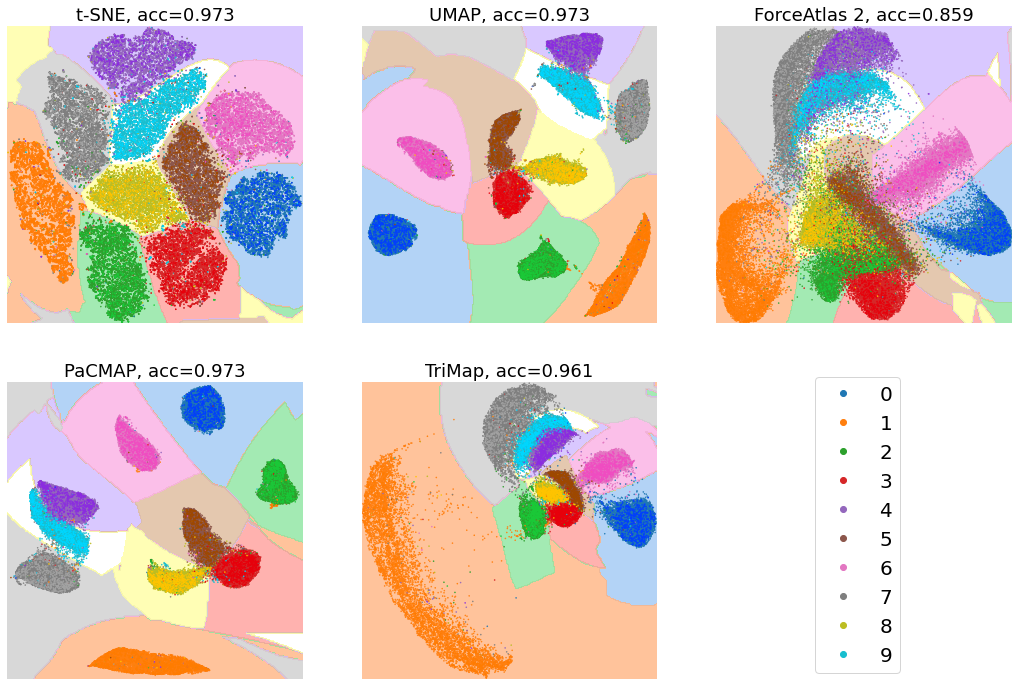

In [27]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()
keys = ['TSNE', 'UMAP', 'FA2', 'PACMAP', 'TRIMAP']
names = ['t-SNE', 'UMAP', 'ForceAtlas 2', 'PaCMAP', 'TriMap']
for i in range(5):
    x_min, x_max = results[keys[i]][:, 0].min() - .5, results[keys[i]][:, 0].max() + .5 
    y_min, y_max = results[keys[i]][:, 1].min() - .5, results[keys[i]][:, 1].max() + .5 
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 251), np.linspace(y_min, y_max, 251))

    axes[i].contourf(xx, yy, Zs[keys[i]], colors=sns.color_palette("pastel", n_colors=10).as_hex(), alpha=.8, levels=np.arange(10)-0.1)
    sc = axes[i].scatter(results[keys[i]][train_index, 0], results[keys[i]][train_index, 1],\
                    cmap=my_cmap, c=y_train, s=0.3)
    axes[i].scatter(results[keys[i]][test_index, 0], results[keys[i]][test_index, 1],\
                    cmap=my_cmap_2, c=y_test, s=0.3)
    axes[i].axis('off')
    axes[i].set_title(f"{names[i]}, acc={scores[i]}", fontsize=18)
axes[5].axis('off')
axes[4].legend(*sc.legend_elements(), bbox_to_anchor=(1.5,1.05), loc='upper left', fontsize=20)

# plt.savefig('/Users/hyhuang/Desktop/MNIST_DR_NEW.png')

In [28]:
new_colors = ['#2e294e', "#FF1053", "#D3C0CD", "#7E9181", "#00A676", "#78C0E0", "#449DD1", "#EDEEC0", "#601700", "#A37C40"]
new_colormap = ListedColormap(new_colors)

In [29]:
spe = ["#192BC2","#017e91","#00a896","#60d198","#e7ed97","#f8bf94","#ff8b6b","#f25c54","#e0263e","#b5102e"]
spe_colormap = ListedColormap(spe)

In [30]:
spe_bg = ["#4e83bc","#01d3f4","#0affe7","#91deb8","#f3f6cb","#fbddc5","#ffaf99","#f5807a","#e85e71","#eb1e43"]
spebg_colormap = ListedColormap(spe_bg)

In [31]:
exc = ["#6f7bec","#01d3f4","#0affe7","#91deb8","#f3f6cb","#fbddc5","#eb4789","#c7ef00","#b09e99","#eb1e43"]
exc_colormap = ListedColormap(exc)

In [32]:
exc_it = ["#1c2fd9","#019eb7","#00ccb8","#52cb8f","#d7e052","#f29040","#b81456","#99b800","#685550","#bc1030"]
excit_colormap = ListedColormap(exc_it)

In [33]:
cs = ["#f94144","#f3722c","#f8961e","#f9844a","#f9c74f","#90be6d","#43aa8b","#4d908e","#577590","#277da1"]
cs_cmap = ListedColormap(cs)

In [34]:
dai = ["#3b1f2b","#e23b3e","#f8961e","#f9844a","#f9c74f","#90be6d","#43aa8b","#4d908e","#577590","#277da1"]
daibg = ["#8a586e","#da8c8d","#e4b67e","#e9b195","#e9d199","#b5caa5","#85bdad","#87b1b0","#8fa0b0","#69a7c2"]
dai_map = ListedColormap(dai)
daibg_map = ListedColormap(daibg)

TSNE SVM score with rbf kernel is 0.967

UMAP SVM score with rbf kernel is 0.969

PACMAP SVM score with rbf kernel is 0.969

TRIMAP SVM score with rbf kernel is 0.962

FA2 SVM score with rbf kernel is 0.860


In [36]:
scores = [0.973, 0.973, 0.859, 0.973, 0.961]

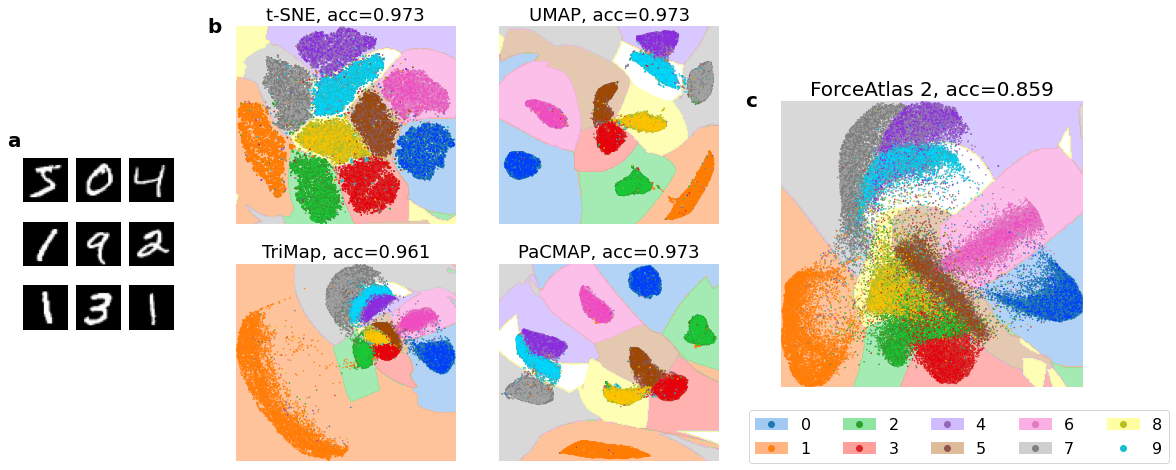

In [40]:
fig = plt.figure(figsize=(19, 8))
keys = ['TSNE', 'UMAP', 'FA2', 'PACMAP', 'TRIMAP']
names = ['t-SNE', 'UMAP', 'ForceAtlas 2', 'PaCMAP', 'TriMap']
gs = fig.add_gridspec(1, 3, width_ratios=[0.5, 1.6, 1])
gs0 = gs[0].subgridspec(7, 3)
gs1 = gs[1].subgridspec(2, 2)
gs2 = gs[2].subgridspec(6, 6)
X_img = np.load("../../data/mnist_images.npy",
            allow_pickle=True)
for i in range(9):
    Xi = X_img[i].reshape(28, 28)
    ax = fig.add_subplot(gs0[i//3 + 2, i%3])
    ax.imshow(Xi, cmap='gray')
    ax.axis('off')
    if i == 0:
        ax.text(-0.2, 1.4, 'a', fontsize=20, weight='bold', ha='center', va='center', transform=ax.transAxes)

ax = fig.add_subplot(gs2[1:5, :])
x_min, x_max = results[keys[2]][:, 0].min() - .5, results[keys[2]][:, 0].max() + .5 
y_min, y_max = results[keys[2]][:, 1].min() - .5, results[keys[2]][:, 1].max() + .5 
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 251), np.linspace(y_min, y_max, 251))
ax.contourf(xx, yy, Zs[keys[2]], colors=sns.color_palette("pastel", n_colors=10).as_hex(), alpha=.8, \
            levels=np.arange(10)-0.1)
sc = ax.scatter(results[keys[2]][train_index, 0], results[keys[2]][train_index, 1],\
                cmap=my_cmap, c=y_train, s=0.3)
ax.scatter(results[keys[2]][test_index, 0], results[keys[2]][test_index, 1],\
                cmap=my_cmap_2, c=y_test, s=0.3)
ax.axis('off')
ax.set_title(f"{names[2]}, acc={scores[2]}", fontsize=20)
ax.text(-0.1, 1, 'c', fontsize=20, weight='bold', ha='center', va='center', transform=ax.transAxes)

for i in range(2):
    fax = fig.add_subplot(gs1[0, i])
    x_min, x_max = results[keys[i]][:, 0].min() - .5, results[keys[i]][:, 0].max() + .5 
    y_min, y_max = results[keys[i]][:, 1].min() - .5, results[keys[i]][:, 1].max() + .5 
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 251), np.linspace(y_min, y_max, 251))

    fax.contourf(xx, yy, Zs[keys[i]], colors=sns.color_palette("pastel", n_colors=10).as_hex(),\
                 alpha=.8, levels=np.arange(10)-0.1)
    sc = fax.scatter(results[keys[i]][train_index, 0], results[keys[i]][train_index, 1],\
                    cmap=my_cmap, c=y_train, s=0.3)
    fax.scatter(results[keys[i]][test_index, 0], results[keys[i]][test_index, 1],\
                    cmap=my_cmap_2, c=y_test, s=0.3)
    fax.axis('off')
    fax.set_title(f"{names[i]}, acc={scores[i]}", fontsize=18)
    if i == 0:
        fax.text(-0.1, 1, 'b', fontsize=20, weight='bold', ha='center', va='center', transform=fax.transAxes)


# TriMap
key = 'TRIMAP'
fax = fig.add_subplot(gs1[1, 0])
x_min, x_max = results[key][:, 0].min() - .5, results[key][:, 0].max() + .5 
y_min, y_max = results[key][:, 1].min() - .5, results[key][:, 1].max() + .5 
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 251), np.linspace(y_min, y_max, 251))

fax.contourf(xx, yy, Zs[key], colors=sns.color_palette("pastel", n_colors=10).as_hex(), \
             alpha=.8, levels=np.arange(10)-0.1)
sc = fax.scatter(results[key][train_index, 0], results[key][train_index, 1],\
                cmap=my_cmap, c=y_train, s=0.3)
fax.scatter(results[key][test_index, 0], results[key][test_index, 1],\
                cmap=my_cmap_2, c=y_test, s=0.3)
fax.axis('off')
fax.set_title(f"{names[4]}, acc={scores[4]}", fontsize=18)

# PaCMAP
key = 'PACMAP'
fax = fig.add_subplot(gs1[1, 1])
x_min, x_max = results[key][:, 0].min() - .5, results[key][:, 0].max() + .5 
y_min, y_max = results[key][:, 1].min() - .5, results[key][:, 1].max() + .5 
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 251), np.linspace(y_min, y_max, 251))

fax.contourf(xx, yy, Zs[key], colors=sns.color_palette("pastel", n_colors=10).as_hex(), \
             alpha=.8, levels=np.arange(10)-0.1)
sc = fax.scatter(results[key][train_index, 0], results[key][train_index, 1],\
                cmap=my_cmap, c=y_train, s=0.3)
fax.scatter(results[key][test_index, 0], results[key][test_index, 1],\
                cmap=my_cmap_2, c=y_test, s=0.3)
fax.axis('off')
fax.set_title(f"{names[3]}, acc={scores[3]}", fontsize=18)

import matplotlib.patches as mpatches
patches = []
for i in range(10):
    if i < 9:
        patch = (mpatches.Patch(color=sns.color_palette("pastel", n_colors=10).as_hex()[i]), 
                 sc.legend_elements()[0][i])
    else:
        patch = (mpatches.Patch(color='#ffffff'), 
                 sc.legend_elements()[0][i])

    patches.append(patch)
fax.legend(handles=patches, labels=sc.legend_elements()[1], 
           bbox_to_anchor=(1.1, 0.3), loc='upper left', 
           fontsize=16, ncol=5)
# fax.legend(*sc.legend_elements(), bbox_to_anchor=(1.1, 0.3), loc='upper left', fontsize=16, ncol=5)
plt.savefig('./MNIST_svm_new.png')

In [41]:
sc.legend_elements()[0][0]

In [42]:
sns.color_palette("pastel", n_colors=10).as_hex()

['#a1c9f4',
 '#ffb482',
 '#8de5a1',
 '#ff9f9b',
 '#d0bbff',
 '#debb9b',
 '#fab0e4',
 '#cfcfcf',
 '#fffea3',
 '#b9f2f0']

In [43]:
type(sc.legend_elements())

tuple

In [44]:
# KNN
KNNs = {}
for key, entries in results.items():
    X_train, X_test = entries[train_index], entries[test_index]
    clf = KNeighborsClassifier()
    clf.fit(X_train, y_train)
    KNNs[key] = clf

In [45]:
Zs2 = {}
for i in range(5):
    x_min, x_max = results[keys[i]][:, 0].min() - .5, results[keys[i]][:, 0].max() + .5 
    y_min, y_max = results[keys[i]][:, 1].min() - .5, results[keys[i]][:, 1].max() + .5 
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 251), np.linspace(y_min, y_max, 251))
    Z = KNNs[keys[i]].predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    Zs2[keys[i]] = Z


In [46]:
for key, svm in KNNs.items():
    print(f"{key} knn score is {svm.score(results[key][test_index], y_test):.3f}")

TSNE knn score is 0.977
UMAP knn score is 0.974
PACMAP knn score is 0.973
TRIMAP knn score is 0.962
FA2 knn score is 0.845


In [47]:
scores2 = [0.977, 0.974, 0.973, 0.962, 0.845]

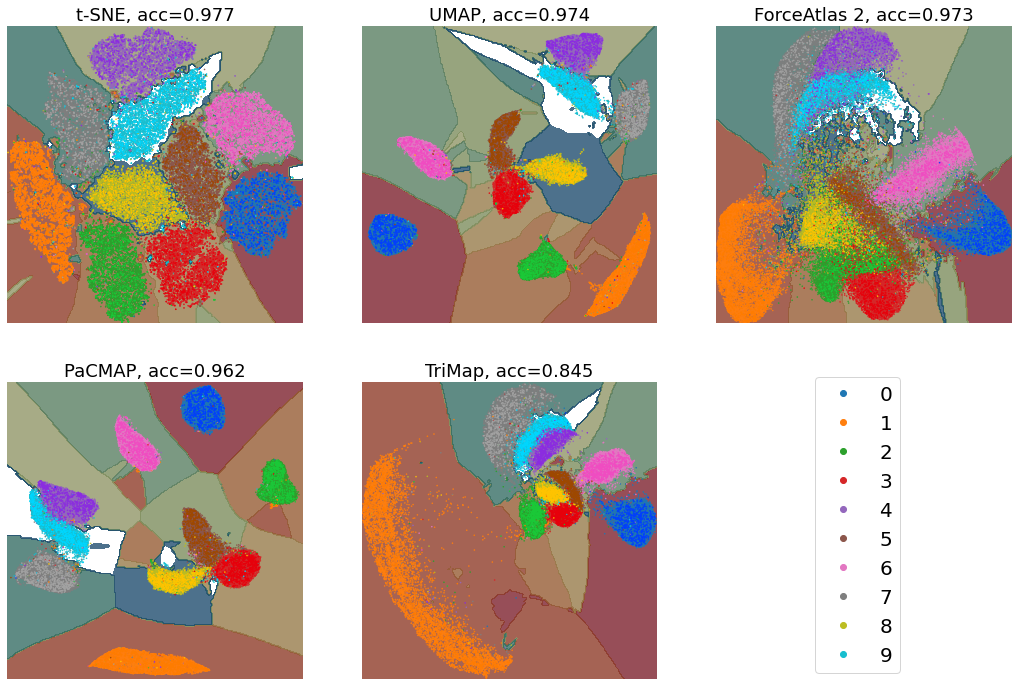

In [48]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()
for i in range(5):
    x_min, x_max = results[keys[i]][:, 0].min() - .5, results[keys[i]][:, 0].max() + .5 
    y_min, y_max = results[keys[i]][:, 1].min() - .5, results[keys[i]][:, 1].max() + .5 
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 251), np.linspace(y_min, y_max, 251))

    axes[i].contourf(xx, yy, Zs2[keys[i]], cmap=my_cmap_background, alpha=.8, levels=np.arange(10)-0.1)
    sc = axes[i].scatter(results[keys[i]][train_index, 0], results[keys[i]][train_index, 1],\
                    cmap=my_cmap, c=y_train, s=0.3)
    axes[i].scatter(results[keys[i]][test_index, 0], results[keys[i]][test_index, 1],\
                    cmap=my_cmap_2, c=y_test, s=0.3)
    axes[i].axis('off')
    axes[i].set_title(f"{names[i]}, acc={scores2[i]}", fontsize=18)
axes[5].axis('off')
axes[4].legend(*sc.legend_elements(), bbox_to_anchor=(1.5,1.05), loc='upper left', fontsize=20)


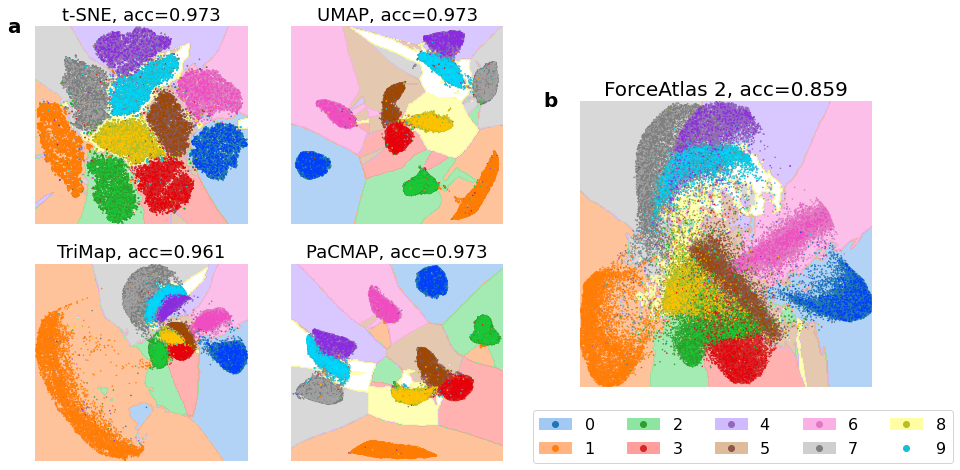

In [49]:
fig = plt.figure(figsize=(15, 8))
#constrained_layout=True
gs = fig.add_gridspec(1, 2, width_ratios=[1.6, 1])
gs2 = gs[1].subgridspec(6, 6)
gs1 = gs[0].subgridspec(2, 2)

ax = fig.add_subplot(gs2[1:5, :])
x_min, x_max = results[keys[2]][:, 0].min() - .5, results[keys[2]][:, 0].max() + .5 
y_min, y_max = results[keys[2]][:, 1].min() - .5, results[keys[2]][:, 1].max() + .5 
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 251), np.linspace(y_min, y_max, 251))
ax.contourf(xx, yy, Zs2[keys[2]], colors=sns.color_palette("pastel", n_colors=10).as_hex(), alpha=.8, \
            levels=np.arange(10)-0.1)
sc = ax.scatter(results[keys[2]][train_index, 0], results[keys[2]][train_index, 1],\
                cmap=my_cmap, c=y_train, s=0.3)
ax.scatter(results[keys[2]][test_index, 0], results[keys[2]][test_index, 1],\
                cmap=my_cmap_2, c=y_test, s=0.3)
ax.axis('off')
ax.set_title(f"{names[2]}, acc={scores[2]}", fontsize=20)
ax.text(-0.1, 1, 'b', fontsize=20, weight='bold', ha='center', va='center', transform=ax.transAxes)


for i in range(2):
    fax = fig.add_subplot(gs1[0, i])
    x_min, x_max = results[keys[i]][:, 0].min() - .5, results[keys[i]][:, 0].max() + .5 
    y_min, y_max = results[keys[i]][:, 1].min() - .5, results[keys[i]][:, 1].max() + .5 
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 251), np.linspace(y_min, y_max, 251))

    fax.contourf(xx, yy, Zs2[keys[i]], colors=sns.color_palette("pastel", n_colors=10).as_hex(),\
                 alpha=.8, levels=np.arange(10)-0.1)
    sc = fax.scatter(results[keys[i]][train_index, 0], results[keys[i]][train_index, 1],\
                    cmap=my_cmap, c=y_train, s=0.3)
    fax.scatter(results[keys[i]][test_index, 0], results[keys[i]][test_index, 1],\
                    cmap=my_cmap_2, c=y_test, s=0.3)
    fax.axis('off')
    fax.set_title(f"{names[i]}, acc={scores[i]}", fontsize=18)
    if i == 0:
        fax.text(-0.1, 1, 'a', fontsize=20, weight='bold', ha='center', va='center', transform=fax.transAxes)


# TriMap
key = 'TRIMAP'
fax = fig.add_subplot(gs1[1, 0])
x_min, x_max = results[key][:, 0].min() - .5, results[key][:, 0].max() + .5 
y_min, y_max = results[key][:, 1].min() - .5, results[key][:, 1].max() + .5 
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 251), np.linspace(y_min, y_max, 251))

fax.contourf(xx, yy, Zs2[key], colors=sns.color_palette("pastel", n_colors=10).as_hex(), \
             alpha=.8, levels=np.arange(10)-0.1)
sc = fax.scatter(results[key][train_index, 0], results[key][train_index, 1],\
                cmap=my_cmap, c=y_train, s=0.3)
fax.scatter(results[key][test_index, 0], results[key][test_index, 1],\
                cmap=my_cmap_2, c=y_test, s=0.3)
fax.axis('off')
fax.set_title(f"{names[4]}, acc={scores[4]}", fontsize=18)

# PaCMAP
key = 'PACMAP'
fax = fig.add_subplot(gs1[1, 1])
x_min, x_max = results[key][:, 0].min() - .5, results[key][:, 0].max() + .5 
y_min, y_max = results[key][:, 1].min() - .5, results[key][:, 1].max() + .5 
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 251), np.linspace(y_min, y_max, 251))

fax.contourf(xx, yy, Zs2[key], colors=sns.color_palette("pastel", n_colors=10).as_hex(), \
             alpha=.8, levels=np.arange(10)-0.1)
sc = fax.scatter(results[key][train_index, 0], results[key][train_index, 1],\
                cmap=my_cmap, c=y_train, s=0.3)
fax.scatter(results[key][test_index, 0], results[key][test_index, 1],\
                cmap=my_cmap_2, c=y_test, s=0.3)
fax.axis('off')
fax.set_title(f"{names[3]}, acc={scores[3]}", fontsize=18)

for i in range(10):
    if i < 9:
        patch = (mpatches.Patch(color=sns.color_palette("pastel", n_colors=10).as_hex()[i]), 
                 sc.legend_elements()[0][i])
    else:
        patch = (mpatches.Patch(color='#ffffff'), 
                 sc.legend_elements()[0][i])

    patches.append(patch)
fax.legend(handles=patches, labels=sc.legend_elements()[1], 
           bbox_to_anchor=(1.1, 0.3), loc='upper left', 
           fontsize=16, ncol=5)
plt.savefig('./MNIST_knn_new.png')